**City Divider**
Reclustering the city using foursquare data and KMeans clustering.

# Imports 

In [2]:
import pandas as pd
import numpy as np
import geopandas
import shapely
from shapely.ops import cascaded_union
import json
import requests
import geovoronoi
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
from config import *

# Foursquare API Call

## Get Data function

In [175]:
def get_foursquare_data(LIMIT, radius=4000, lat = 40.933353, lng = -73.781987,
                        client_id=CLIENT_ID, client_secret=CLIENT_SECRET, version=VERSION):
    # 1 mile ~= 1600 meters... 4 mile radius covers most of populated new rochelle
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        client_id, 
        client_secret, 
        version, 
        lat, 
        lng, 
        radius, 
        LIMIT)
    results = requests.get(url).json()["response"]['venues']
    return results

## Parse data function

In [144]:
def parse_foursquare_data(request):
    all_data = []
    for x in request:
#         venue = x['venue']
#         categories = [x['name'] for x in venue['categories']] #in case there are >1 categories for a venue
        try:
            categories = x['categories'][0]['name'] #in case there are >1 categories for a venue
        except IndexError:
            categories = None
        try:
            city = x['location']['city']
        except KeyError:
            city = None
        new_data = [x['name'], x['location']['lat'], x['location']['lng'], city, 
                   categories]
        all_data.append(new_data)
    df = pd.DataFrame(data=all_data, 
                      columns = ['id', 'location_lat', 'location_lng', 'location_city', 'category'])
    return df

## Making Calls

In [152]:
# the_data = get_foursquare_data(LIMIT=1000)

In [168]:
df = parse_foursquare_data(the_data)

## Making more api calls and then combining results 

### Setting up big_df

In [227]:
# setting up for loop to adjust the longitude of the calls
big_df = df.copy()

In [192]:
big_df.head(2)

,id,location_lat,location_lng,location_city,category
0,Thornton Donovan School,40.933228,-73.781912,New Rochelle,High School
1,Beechmont Lake,40.931245,-73.779182,New Rochelle,Lake


### For loop to change location of search

In [191]:
lat_range = list(range(40977, 40899, -7))
actual_lat_range = np.array(lat_range) / 1000
len(actual_lat_range)

12

In [228]:
empty_df = pd.DataFrame()
for x in actual_lat_range:
    the_data = get_foursquare_data(LIMIT=250, radius = 2000, lat=x)
    parsed_data = parse_foursquare_data(the_data)
    big_df = pd.concat([big_df, parsed_data])

In [229]:
big_df.shape

(1557, 5)

In [238]:
big_df.head(2)

,id,location_lat,location_lng,location_city,category
0,Thornton Donovan School,40.933228,-73.781912,New Rochelle,High School
1,Beechmont Lake,40.931245,-73.779182,New Rochelle,Lake


## Examining and limiting big_df

### Cities

In [242]:
# none of the items have multiple categories
# what cities are all of these places in?
big_df.location_city.value_counts()

New Rochelle    1271
Scarsdale        140
Larchmont         20
New York           9
Westchester        6
Pelham             6
White Plains       4
Bronx              3
Nanuet             3
Stamford           3
Eastchester        2
Hawthorne          2
Mamaroneck         2
Mount Vernon       2
Brooklyn           2
Rye                2
Yonkers            1
New Paltz          1
Heathcote          1
Astoria            1
Irvington          1
Greenwich          1
Tuckahoe           1
Rochelle           1
Fort Lee           1
Dr                 1
Name: location_city, dtype: int64

#### Setting up possible coordinates in a polygon shape

In [244]:
# here's the census's bbox [-73.807197, 40.871721, -73.740597, 40.9887]
## we will slightly extended the coordinates for the box of new rochelle and limit results to ones inside that
lat_range = (40.85, 41)
lng_range = (-73.73, -73.82)

#### Removing values

In [265]:
big_df.shape

(1557, 5)

In [253]:
big_df1 = big_df[(lat_range[0] < big_df['location_lat']) & (big_df['location_lat'] < lat_range[1])]

In [255]:
big_df1.shape

(1554, 5)

In [269]:
big_df2 = big_df1[(lng_range[0] > big_df1['location_lng']) & (big_df1['location_lng'] > lng_range[1])]

In [284]:
type(big_df2.iloc[2]['category'])

NoneType

### Categories

#### Firstly, removing all None categories

In [296]:
big_df2['empty_catgory'] = big_df2['category'].isnull()

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [300]:
big_df3 = big_df2[big_df2['empty_catgory'] == False]

In [302]:
big_df3.shape

(1382, 6)

In [303]:
category_counts = big_df3.category.value_counts()

In [304]:
# some of the categories have <2 venues, so I will drop them
important_categories = list(category_counts[category_counts > 2].index)

#### Only Selecting Relevant Categories

In [323]:
relevant_categories= ['Salon / Barbershop', 'Deli / Bodega','Gas Station','Pizza Place','Gym',
                     'Ice Cream Shop','Playground','Park','Nail Salon','Baseball Field','Liquor Store',
                     'Grocery Store','Sandwich Place','Bagel Shop','Gym / Fitness Center','Bank','Soccer Field',
                     'Tennis Court','Pharmacy','Mobile Phone Shop','Coffee Shop','Bar','Fire Station',
                     'Supermarket','Elementary School','Middle School','Train Station','Café']

In [324]:
big_df4 = big_df3[big_df3['category'].isin(relevant_categories)]
# df2 = big_df[big_df['category'].isin(important_categories)]

In [325]:
big_df4.shape

(330, 6)

In [326]:
big_df4.head()

,id,location_lat,location_lng,location_city,category,empty_catgory
4,Starbucks,40.925174,-73.787628,New Rochelle,Coffee Shop,False
20,Soccer training field,40.929202,-73.773256,New Rochelle,Soccer Field,False
31,Mazella Field,40.927031,-73.785898,New Rochelle,Soccer Field,False
33,Sidelsky Field,40.929792,-73.773184,New Rochelle,Soccer Field,False
36,B&A deli,40.927223,-73.789566,New Rochelle,Deli / Bodega,False


#### Getting count of items for each category

In [333]:
big_df4.category.value_counts()

Salon / Barbershop      36
Deli / Bodega           27
Gas Station             23
Pizza Place             18
Gym                     17
Park                    13
Ice Cream Shop          13
Playground              13
Baseball Field          13
Nail Salon              13
Liquor Store            12
Grocery Store           11
Bagel Shop              10
Bank                    10
Soccer Field            10
Sandwich Place          10
Gym / Fitness Center    10
Pharmacy                 9
Tennis Court             9
Coffee Shop              8
Mobile Phone Shop        8
Fire Station             7
Bar                      7
Supermarket              6
Elementary School        5
Middle School            5
Train Station            4
Café                     3
Name: category, dtype: int64

In [327]:
big_df4.reset_index(inplace=True)

# Mapping all of the Venues

## Base map

In [328]:
# base map centered on new ro 
base_lat = 40.925
base_long = -73.7824
#base_map = folium.Map([base_lat, base_long], zoom_start=10, tiles="cartodbpositron")
base_map = folium.Map([base_lat, base_long], zoom_start=13, tiles="cartodbpositron")

## Adding Locations

In [330]:
for index, item in enumerate(big_df4['id']):
    folium.Marker(
            location = (big_df4['location_lat'][index], big_df4['location_lng'][index]),
            popup = big_df4['category'][index],
            icon=folium.Icon(color='purple')
        ).add_to(base_map)

In [331]:
base_map

## Saving the map

In [334]:
# base_map.save("Venue_locations_in_NR.html")

# Clustering the businesses

## Preparing Data 

In [379]:
big_df4.head(2)

,index,id,location_lat,location_lng,location_city,category,empty_catgory
0,4,Starbucks,40.925174,-73.787628,New Rochelle,Coffee Shop,False
1,20,Soccer training field,40.929202,-73.773256,New Rochelle,Soccer Field,False


In [336]:
kmeans_df = big_df4[['location_lat', 'location_lng', 'category']]

In [338]:
kmeans_df.head(2)

,location_lat,location_lng,category
0,40.925174,-73.787628,Coffee Shop
1,40.929202,-73.773256,Soccer Field


# Clustering the businesses by location

## kmeans

In [377]:
kmeans_df_nocat = kmeans_df.drop(columns='category')

In [378]:
kclusters_nocat = 5
kmeans_nocat = KMeans(n_clusters = kclusters_nocat, random_state = 0).fit(kmeans_df_nocat)

In [380]:
len(kmeans_nocat.labels_)

330

In [381]:
kmeans_df_nocat.insert(0, 'Cluster Labels', kmeans_nocat.labels_)

## Plotting

In [382]:
kmeans_df_nocat1 = pd.concat([kmeans_df_nocat, kmeans_df['category']], axis=1)

In [383]:
kmeans_df_nocat1.shape

(330, 4)

In [384]:
kmeans_df_nocat1.head(2)

,Cluster Labels,location_lat,location_lng,category
0,1,40.925174,-73.787628,Coffee Shop
1,1,40.929202,-73.773256,Soccer Field


In [385]:
base_map3 = folium.Map([base_lat, base_long], zoom_start=13, tiles="cartodbpositron")
color_list = ['pink', 'gray', 'green', 'red', 'purple']

In [386]:
for index, item in enumerate(kmeans_df_nocat1['location_lat']):
    cluster_num = kmeans_df_nocat1['Cluster Labels'][index]
    folium.Marker(
            location = (kmeans_df_nocat1['location_lat'][index], kmeans_df_nocat1['location_lng'][index]),
            popup = kmeans_df_nocat1['category'][index],
            icon=folium.Icon(color=color_list[cluster_num])
        ).add_to(base_map3)

In [387]:
# so it picked the places randomly when it had the category attached
base_map3

## Saving new map

In [388]:
# base_map.save("Venue_locations_clustered_in_NR.html")

## Meta Categories

In [393]:
categories = kmeans_df['category'].unique()
categories

array(['Coffee Shop', 'Soccer Field', 'Deli / Bodega', 'Gym', 'Park',
       'Playground', 'Baseball Field', 'Tennis Court',
       'Elementary School', 'Pharmacy', 'Salon / Barbershop', 'Bar',
       'Liquor Store', 'Ice Cream Shop', 'Sandwich Place',
       'Gym / Fitness Center', 'Pizza Place', 'Grocery Store',
       'Gas Station', 'Bank', 'Nail Salon', 'Bagel Shop', 'Fire Station',
       'Middle School', 'Supermarket', 'Mobile Phone Shop', 'Café',
       'Train Station'], dtype=object)

In [399]:
recreation = ['Soccer Field','Gym', 'Park','Playground', 'Baseball Field', 'Tennis Court','Gym / Fitness Center']
schools = ['Elementary School',  'Middle School']
essentials = ['Pharmacy','Salon / Barbershop','Grocery Store','Gas Station','Supermarket']
services = ['Fire Station','Bank','Train Station','Mobile Phone Shop']
food_rec = ['Deli / Bodega','Coffee Shop','Bar','Liquor Store', 'Ice Cream Shop', 'Sandwich Place','Pizza Place',
           'Nail Salon', 'Bagel Shop','Café']

In [400]:
len(categories)

28

In [401]:
len(recreation) + len(schools) + len(essentials) + len(services) + len(food_rec)

28

### meta df

In [408]:
kmeans_df_meta = kmeans_df.copy()

In [404]:
kmeans_df_meta['meta_category'] = "Blank"

In [409]:
kmeans_df_meta['services'] = kmeans_df_meta['category'].isin(services)

In [411]:
kmeans_df_meta['recreation'] = kmeans_df_meta['category'].isin(recreation)

In [412]:
kmeans_df_meta['schools'] = kmeans_df_meta['category'].isin(schools)

In [413]:
kmeans_df_meta['essentials'] = kmeans_df_meta['category'].isin(essentials)

In [414]:
kmeans_df_meta['food_rec'] = kmeans_df_meta['category'].isin(food_rec)

### kmeans

In [415]:
kmeans_df_meta

,location_lat,location_lng,category,services,recreation,schools,essentials,food_rec
0,40.925174,-73.787628,Coffee Shop,False,False,False,False,True
1,40.929202,-73.773256,Soccer Field,False,True,False,False,False
2,40.927031,-73.785898,Soccer Field,False,True,False,False,False
3,40.929792,-73.773184,Soccer Field,False,True,False,False,False
4,40.927223,-73.789566,Deli / Bodega,False,False,False,False,True
...,...,...,...,...,...,...,...,...
325,40.898741,-73.777869,Salon / Barbershop,False,False,False,True,False
326,40.898827,-73.777857,Salon / Barbershop,False,False,False,True,False
327,40.897134,-73.777672,Nail Salon,False,False,False,False,True
328,40.895933,-73.779405,Playground,False,True,False,False,False


In [416]:
kmeans_df_meta_nocat = kmeans_df_meta.drop(columns='category')

In [417]:
kclusters_nocat_meta = 5
kmeans_nocat_meta = KMeans(n_clusters = kclusters_nocat_meta, random_state = 0).fit(kmeans_df_meta_nocat)

In [418]:
kmeans_df_meta_nocat.insert(0, 'Cluster Labels', kmeans_nocat_meta.labels_)

In [427]:
kmeans_df_meta_nocat.head(3)

,Cluster Labels,location_lat,location_lng,services,recreation,schools,essentials,food_rec
0,2,40.925174,-73.787628,False,False,False,False,True
1,1,40.929202,-73.773256,False,True,False,False,False
2,1,40.927031,-73.785898,False,True,False,False,False


In [422]:
# I think all of the labels became the categories
kmeans_df_meta_nocat.groupby('Cluster Labels').recreation.value_counts()

Cluster Labels  recreation
0               False          85
1               True           85
2               False         121
3               False          29
4               False          10
Name: recreation, dtype: int64

In [424]:
kmeans_df_meta_nocat.recreation.sum()

85

### Grouping by subcategory

#### services

In [450]:
services_df = kmeans_df_meta_nocat[kmeans_df_meta_nocat['services'] == True]

In [451]:
services_df.drop(columns=['Cluster Labels'], inplace=True)
services_df.reset_index(drop = True, inplace=True)

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [452]:
kclusters_nocat_meta = 5
kmeans_services = KMeans(n_clusters = kclusters_nocat_meta, random_state = 0).fit(services_df)

In [453]:
kmeans_services.labels_

array([0, 0, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [454]:
services_df.insert(0, 'Cluster Labels', kmeans_services.labels_)

In [455]:
services_df.head(2)

,Cluster Labels,location_lat,location_lng,services,recreation,schools,essentials,food_rec
0,0,40.984574,-73.774359,True,False,False,False,False
1,0,40.984975,-73.776831,True,False,False,False,False


##### Plotting

In [456]:
base_map4 = folium.Map([base_lat, base_long], zoom_start=13, tiles="cartodbpositron")

In [457]:
for index, item in enumerate(services_df['location_lat']):
    cluster_num = services_df['Cluster Labels'][index]
    folium.Marker(
            location = (services_df['location_lat'][index], services_df['location_lng'][index]),
            icon=folium.Icon(color=color_list[cluster_num])
        ).add_to(base_map4)

In [458]:
# the grouping of things was a little weird just because the index columns was still there
base_map4

#### Essentials

In [473]:
essentials_df = kmeans_df_meta_nocat[kmeans_df_meta_nocat['essentials'] == True]

In [474]:
essentials_df.drop(columns=['Cluster Labels'], inplace=True)
essentials_df.reset_index(drop = True, inplace=True)

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [475]:
kclusters_nocat_meta = 6
kmeans_essentials = KMeans(n_clusters = kclusters_nocat_meta, random_state = 0).fit(essentials_df)

In [481]:
kmeans_essentials.labels_

array([4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 5, 5, 3, 3, 5, 5, 5, 5, 5, 3, 5, 5, 3, 5, 5, 3, 5, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [476]:
essentials_df.insert(0, 'Cluster Labels', kmeans_essentials.labels_)

In [477]:
essentials_df.head(2)

,Cluster Labels,location_lat,location_lng,services,recreation,schools,essentials,food_rec
0,4,40.984264,-73.777399,False,False,False,True,False
1,4,40.985290,-73.776861,False,False,False,True,False


In [478]:
base_map5 = folium.Map([base_lat, base_long], zoom_start=13, tiles="cartodbpositron")

In [483]:
color_list2 = ['pink', 'gray', 'green', 'red', 'purple', 'blue']

In [485]:
for index, item in enumerate(essentials_df['location_lat']):
    cluster_num = essentials_df['Cluster Labels'][index]
    folium.Marker(
            location = (essentials_df['location_lat'][index], essentials_df['location_lng'][index]),
            popup = (essentials_df['location_lat'][index], essentials_df['location_lng'][index]),
            icon=folium.Icon(color=color_list2[cluster_num])
        ).add_to(base_map5)

In [615]:
base_map5
# base_map5.save("Essential_clusters_NR.html")

# Geovoronoi

## Getting average of each essentials cluster

In [495]:
clustered_essentials = essentials_df.groupby('Cluster Labels')['location_lat', 'location_lng'].mean()

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


## new ro gdf

In [491]:
gpd2 = geopandas.read_file("/Users/gregfeliu/Desktop/Flatiron Bootcamp/Projects/New_Ro_cvs/tl_2019_36_cousub/tl_2019_36_cousub.shp")

In [494]:
gpd2.head(2)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,36,065,08180,00978751,3606508180,Bridgewater,Bridgewater town,43,T1,G4040,None,None,None,A,61757812,29948,+42.9041714,-075.2651320,"POLYGON ((-75.31399 42.93541, -75.30305 42.935..."
1,36,009,27441,00978973,3600927441,Freedom,Freedom town,43,T1,G4040,None,None,None,A,104500723,841642,+42.4713643,-078.3774813,"POLYGON ((-78.44703 42.51921, -78.44688 42.519..."


In [492]:
new_ro_gdf = gpd2.iloc[115]['geometry']

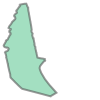

In [500]:
new_ro_gdf

In [502]:
test_coord_values = clustered_essentials.iloc[0].values

In [516]:
np.flip(test_coord_values)

array([-73.77934638,  40.8971511 ])

In [518]:
test_coord_point = shapely.geometry.Point(np.flip(test_coord_values))

In [527]:
def make_coord_to_point(groupbydf):
    lng = groupbydf['location_lng'].values
    lat = groupbydf['location_lat'].values
    points = zip(lng, lat)
    shapely_points = [shapely.geometry.Point(x) for x in points]
    return shapely_points

In [541]:
clustered_points = make_coord_to_point(clustered_essentials)

In [543]:
# all points are within polygon
for item in clustered_points:
    if item.within(new_ro_gdf) == False:
        print(x)

## getting data in correct format

### Making new_ro_gdf into a gdf

In [586]:
type(new_ro_gdf)

shapely.geometry.polygon.Polygon

In [588]:
nr_df = pd.DataFrame(data = ['New Ro', new_ro_gdf])

In [590]:
nr_flipped_df = nr_df.T

In [591]:
nr_flipped_df.columns = ['City', 'geometry']

In [592]:
actual_nr_gdf = geopandas.GeoDataFrame(nr_flipped_df, geometry = 'geometry')

In [594]:
type(actual_nr_gdf)

geopandas.geodataframe.GeoDataFrame

### Back to formatting

In [595]:
actual_nr_gdf.crs = {'init' :'epsg:3395'}

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [596]:
actual_nr_gdf.crs

<Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - between 80°S and 84°N
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### making clustered points to be a gdf

In [547]:
clustered_essentials.index

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64', name='Cluster Labels')

In [553]:
clustered_points_df = pd.DataFrame(data = [clustered_essentials.index,
                                          clustered_points] )

In [555]:
points_df = clustered_points_df.T

In [556]:
points_df.columns = ['Cluster Labels', 'Point']

In [559]:
points_gdf = geopandas.GeoDataFrame(points_df, geometry='Point')

### Back to formatting data

In [562]:
points_gdfactual_nr_gdf.crs = {'init' :'epsg:3395'}

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [584]:
points_gdf.crs

<Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - between 80°S and 84°N
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [597]:
boundary2 = actual_nr_gdf.to_crs(points_gdf.crs)

In [598]:
gdf_proj2 = points_gdf.to_crs(boundary2.crs)

In [599]:
boundary_shape2 = cascaded_union(actual_nr_gdf.geometry)

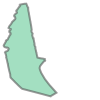

In [600]:
boundary_shape2

In [601]:
coords2 = geovoronoi.points_to_coords(gdf_proj2.geometry)

In [602]:
coords2[0:5]

array([[-73.77934638,  40.8971511 ],
       [-73.78202251,  40.96558433],
       [-73.79351614,  40.94790797],
       [-73.7821418 ,  40.91222545],
       [-73.77719756,  40.9806801 ]])

In [603]:
good_gdf_proj2 = points_gdf.to_crs(boundary2.crs)

In [604]:
poly_shapes2, pts2, poly_to_pt_assignments2 = geovoronoi.voronoi_regions_from_coords(coords2, boundary_shape2,farpoints_max_extend_factor=1000)

## Plotting voronoi regions

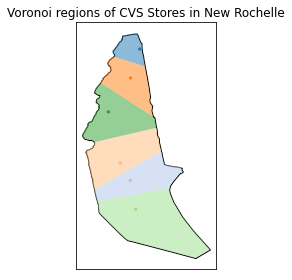

In [613]:
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, boundary_shape2, poly_shapes2, pts2, poly_to_pt_assignments2)
ax.set_title('Voronoi regions of CVS Stores in New Rochelle')
plt.tight_layout()
plt.show()
# fig.savefig("geovoronoi_new_ro_economic_zones.png", bbox_inches = 'tight',
#         pad_inches=0.1)

# Future Directions 

- I ended up using the foursquare api, which is good, except for the lack of control of what you search for
- Using Google api, I could search specifically for:
    - pizzerias
    - gyms
    - phone retailers
    - barber shops / nail salons
    - dry cleaners
    - bars
    - mail offices (usps)
    - atm branches
    - starbucks
    - liquor stores
    - fire/police stations
    - train stations